In [1]:
%pip install -r requirements.txt
%reload_ext autoreload

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-spbstzxh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-spbstzxh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance as dist
import math
from scipy import ndimage
from skimage import measure
import numpy as np
import torch
from raven_dataset import dataset
from torchvision import transforms, utils

path = "/nfs/turbo/coe-chaijy-unreplicated/datasets/RAVEN-10000"
train = dataset(path, "train", 224)

42000


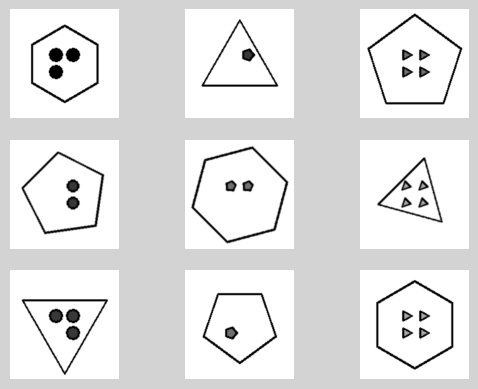

Correct answer: 6


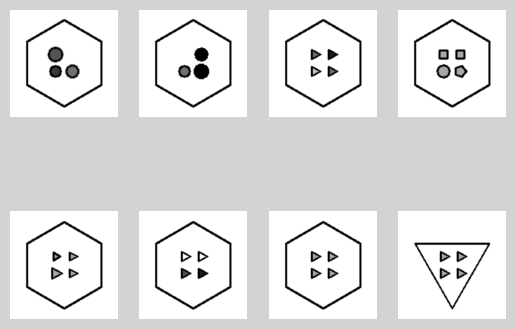

In [4]:
def display_problem(images, answer):
    # show the 3x3 grid of images
    first_eight = images[:9]
    fig, ax = plt.subplots(3, 3)
    for a in ax.ravel():
        a.set_aspect('equal')
    fig.set_facecolor('lightgray')
    for i in range(3):
        for j in range(3):
            if i == 2 and j == 2:
                ax[i, j].imshow(images[8 + answer], cmap='gray')
            else:
                ax[i, j].imshow(first_eight[i * 3 + j], cmap='gray')
            ax[i, j].axis('off')
    plt.show()
    print(f"Correct answer: {answer}")
    # Show the 8 possible answers
    fig, ax = plt.subplots(2, 4)
    for a in ax.ravel():
        a.set_aspect('equal')
    fig.set_facecolor('lightgray')
    for i in range(2):
        for j in range(4):
            ax[i, j].imshow(images[8 + i * 4 + j], cmap='gray')
            ax[i, j].axis('off')
    plt.show()
    # for i in range(16):
    #     plt.imshow(images[i])
    #     plt.show()
print(len(train))
images, target, meta_target, meta_structure, embedding, indicator = train.__getitem__(40000)
display_problem(images, target)
debug_first = False
if debug_first:
    print(cv2.absdiff(images[8 + 0], images[8 + 1]).sum())
    print(cv2.absdiff(images[8 + 2], images[8 + 1]).sum())
    print(cv2.absdiff(images[8 + 0], images[8 + 4]).sum())
    print(cv2.absdiff(images[8], images[10]).sum())
    print(cv2.absdiff(images[8 + 0], images[8 + 2]).sum())
    # display the difference between image[8] and image[9]
    plt.imshow(images[8] - images[9], cmap='gray')
    plt.show()
    plt.imshow(images[10] - images[9], cmap='gray')
    plt.show()
    plt.imshow(images[8] - images[12], cmap='gray')
    plt.show()
    plt.imshow(images[8] - images[10], cmap='gray')
    plt.show()


In [5]:
# Try segmenting images using SAM
from segment_anything import SamPredictor, SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="/nfs/turbo/coe-chaijy-unreplicated/datasets/SAM/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

(896, 896, 3)


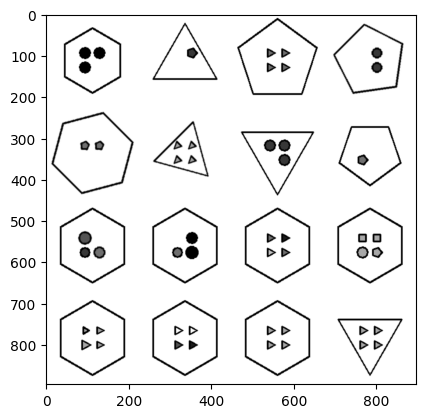

In [6]:
# try 0: multiple, 40000: overlapping, 20000: single objects
images, target, meta_target, meta_structure, embedding, indicator = train.__getitem__(40000)
# image = images[12]
# create image from all 16 images
base_image_shape = images[0].shape
image = np.zeros((base_image_shape[0] * 4, base_image_shape[1] * 4))
for i in range(4):
    for j in range(4):
        image[i * base_image_shape[0]: (i + 1) * base_image_shape[0], j * base_image_shape[1]: (j + 1) * base_image_shape[1]] = images[i * 4 + j]
# image = images[14]
# add a channel dimension
# duplicate the channel dimension 3 times
image = image.reshape(image.shape[0], image.shape[1], 1)
image = np.concatenate([image, image, image], axis=2)
print(image.shape)
# box = np.array([10, 10, 110, 110])
plt.imshow(image)
# plt.plot([box[0], box[2], box[2], box[0], box[0]], [box[1], box[1], box[3], box[3], box[1]], 'r')
plt.show()

In [11]:
# generate all masks
mask_generator = SamAutomaticMaskGenerator(sam, points_per_side=32, box_nms_thresh=0.7)
masks = mask_generator.generate(image)

In [38]:
from math import ceil
def show_anns(image, anns):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    plt.axis("off")
    plt.show()
def color_groups(image, anns, display='groups'):
    colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1]]
    if display == 'single':
        groups = len(anns)
    elif display == 'whole':
        groups = 1
    elif display == 'groups':
        groups = ceil(len(anns) / len(colors))
    show_per_group = ceil(len(anns) / groups)
    for group in range(groups):
        colored_image = np.zeros_like(image)
        first_index = group * show_per_group
        last_index = min((group + 1) * show_per_group, len(anns))
        for i, ann in enumerate(anns[first_index:last_index]):
            colored_image[ann['segmentation']] = colors[i % len(colors)]
        plt.figure(figsize=(10, 10))
        plt.imshow(colored_image)
        plt.axis("off")
        plt.show()
print(f"There are {len(masks)} masks")
print(masks[0])
x1, y1, x2, y2 = masks[0]['bbox']
area = (x2 - x1) * (y2 - y1)
print(masks[0]['bbox'])
print(area)
print(image.shape)
def novelty(i, masks,debug=False):
    mask = masks[i]
    # how much has this mask added, compared to masks before it?
    # keep removing other masks from this, and return the final sum
    novel_mask = mask['segmentation']
    if debug:
        print("Before")
        plt.imshow(novel_mask)
        plt.show()
    for before in range(i):
        novel_mask = np.bitwise_and(novel_mask, np.bitwise_not(masks[before]['segmentation']))
        novel_mask = np.bitwise_and(novel_mask, np.bitwise_not(masks[before]['segmentation']))
    if debug:
        plt.show("After")
        plt.imshow(novel_mask)
        plt.show()
    return novel_mask.sum() / mask['segmentation'].sum()
def valid(i, masks):
    mask = masks[i]
    # reject the mask if it covers the entire image
    _, _, w, h = mask['bbox']
    area = w * h
    if area > 0.90 * image.shape[0] * image.shape[1]:
        return False
    # more checks
    return novelty(i, masks) > 0.5

def chunk_up(masks):
    # Chunk up the image into its 4x4 cells.
    # Put each mask in which cell it belongs to
    cells = [[[] for _ in range(4)] for _ in range(4)]
    cell_width = image.shape[1] // 4
    cell_height = image.shape[0] // 4
    for i, mask in enumerate(masks):
        x, y, w, h = mask['bbox']
        x1, y1, x2, y2 = x, y, x + w, y + h
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)
        x1_id = x1 // cell_width
        y1_id = y1 // cell_height
        x2_id = x2 // cell_width
        y2_id = y2 // cell_height
        # print(f"i={(i)}, x1_id={x1_id}, y1_id={y1_id}, x2_id={x2_id}, y2_id={y2_id} from {mask['bbox']}")
        if x1_id == x2_id and y1_id == y2_id:
            cells[y1_id][x1_id].append(mask)
            
    # flatten the 2d array
    return [cell for row in cells for cell in row]

masks.sort(key=(lambda x: x['predicted_iou']), reverse=True)
# try the first few novelty
# print(novelty(10, masks))
filtered_masks = masks
print("Initial novelties:")
print([novelty(i, filtered_masks) for i, mask in enumerate(filtered_masks)])
print("Initial IOU:")
print([mask['predicted_iou'] for mask in filtered_masks])
# filtered_masks = [mask for mask in filtered_masks if valid(i, filtered_masks)]
print("(filtered) IOU:")
print([mask['predicted_iou'] for mask in filtered_masks])
print(f"There are (filtered) {len(filtered_masks)} masks")
print("Filtered novelties:")
print([novelty(i, filtered_masks) for i, mask in enumerate(filtered_masks)])
# for i in range(10):
#     filtered_masks = [mask for mask in filtered_masks if valid(i, filtered_masks)]
#     print(f"There are (filtered) {len(filtered_masks)} masks")
#     print("Filtered novelties:")
#     print([novelty(i, filtered_masks) for i, mask in enumerate(filtered_masks)])

binary_segmentations = [mask['segmentation'] for mask in filtered_masks]

cells = chunk_up(filtered_masks)

# save this cells data to cells.npz
mask_dtype = np.dtype([('bbox', 'intc', (4,)), ('segmentation', object), ('area', float), ('predicted_iou', float)])

# Convert Mask objects into a structured array
structured_cells = []
sizes = []
for cell in cells:
    # show_anns(image, cell)
    structured_cell = np.zeros(len(cell), dtype=mask_dtype)
    for i, mask in enumerate(cell):
        structured_cell[i]['bbox'] = mask['bbox']
        structured_cell[i]['segmentation'] = mask['segmentation']
        structured_cell[i]['area'] = mask['area']
        structured_cell[i]['predicted_iou'] = mask['predicted_iou']
    structured_cells.append(structured_cell)
    sizes.append(len(cell))
np.savez('cells.npz', masks=structured_cells[0], cell_sizes=sizes)

# show_anns(image, filtered_masks)
# color_groups(image, filtered_masks, display='groups')

There are 87 masks
{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 16666, 'bbox': [44, 33, 137, 158], 'predicted_iou': 1.0153286457061768, 'point_coords': [[126.0, 42.0]], 'stability_score': 0.9896230697631836, 'crop_box': [0, 0, 896, 896]}
[44, 33, 137, 158]
11625
(896, 896, 3)
Initial novelties:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999505856628419, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008802736602052452, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0058964395445508765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00223672377614315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

(87, 802816)


Largest drop with k=27


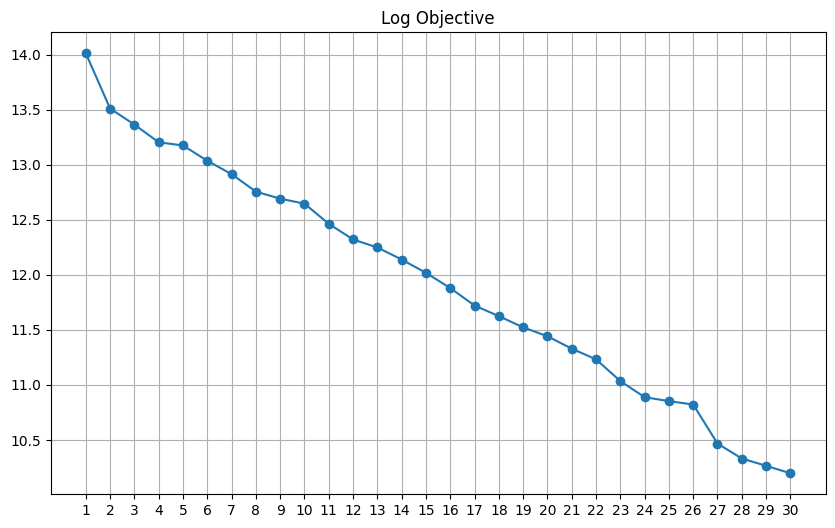

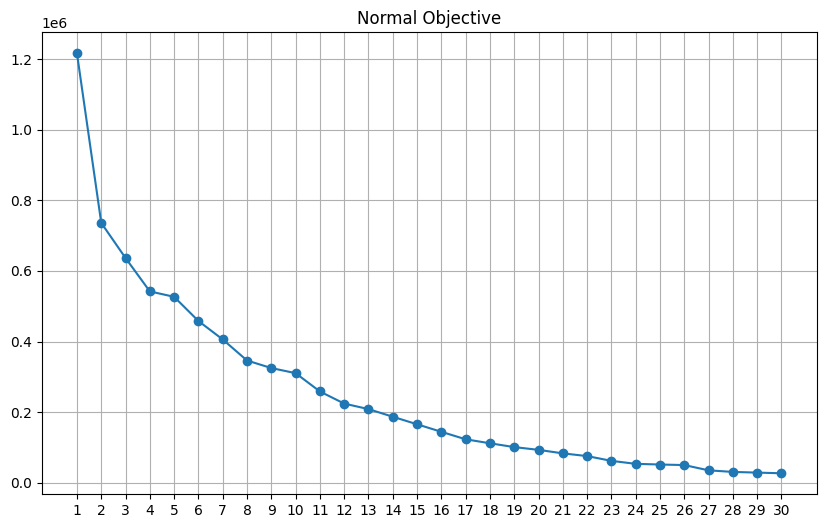

In [9]:
# for each binary segmentation, create a datapoint as a list of coordinates of the mask
from skimage.measure import regionprops, label

# convert binary segmentation to a numpy array datapoint
def extract_features(binary_mask):
    labeled_mask = label(binary_mask)
    props = regionprops(labeled_mask)
    
    # Assuming there is only one object per mask
    if props:
        prop = props[0]
        area = prop.area
        perimeter = prop.perimeter
        if perimeter == 0:
            circularity = 0
        else:
            circularity = 4 * np.pi * area / (perimeter ** 2)
        if prop.major_axis_length == 0:
            aspect_ratio = 0
        else:
            aspect_ratio = prop.minor_axis_length / prop.major_axis_length
        eccentricity = prop.eccentricity
        solidity = prop.solidity
        orientation = prop.orientation
        
        x = [area, perimeter, circularity, aspect_ratio, eccentricity, solidity, orientation]
        x = np.array(x)
        x = binary_mask.flatten()
        return x

# Create a dataset of features
X = []
for binary_segmentation in binary_segmentations:
    X.append(extract_features(binary_segmentation))
X = np.array(X)
print(X.shape)

from sklearn.cluster import KMeans

objectives = []
log_objectives = []

k_max = 30

largest_drop = 0
largest_drop_k = None

for k in range(1, k_max + 1):
    kmeans = KMeans(n_clusters=k, random_state=0, init='k-means++', n_init='auto')
    kmeans.fit(X)
    this_objective = kmeans.inertia_
    this_log_objective = np.log(this_objective)
    objectives.append(this_objective)
    if len(log_objectives) > 1:
        drop = log_objectives[-1] - this_log_objective
        if drop > largest_drop:
            largest_drop = drop
            largest_drop_k = k
    log_objectives.append(this_log_objective)

print(f"Largest drop with k={largest_drop_k}")

# Plot the log objective values against the number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), log_objectives, marker='o')
plt.title('Log Objective')
plt.xticks(range(1, k_max + 1))
plt.grid(True)
plt.show()

# plot normal objective values
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), objectives, marker='o')
plt.title('Normal Objective')
plt.xticks(range(1, k_max + 1))
plt.grid(True)
plt.show()


In [10]:
# Description of image 40000
images_description = [()]